In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Lambda, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, EarlyStopping

In [17]:
from sample.functionImplemented import *
from sample.car import *
from sample.track import *

<h6>Definition of actions:</h6><br>
<ul>  
<li>-1 is <i>Left</i><br>
<li> 0 is <i>As Is</i><br>
<li> 1 is <i>Right</i></ul>

In [17]:
actions=np.asarray([-1, 0, 1]) 

<h6>Model Declaration</h6>

In [340]:
layers=[
(50, 'relu', 0.2),
(200, 'relu', 0.2),
(20, 'relu', 0.2),
(500, 'relu', 0.2)
]

target_model=get_model(layers, 'eval')

make_consistent_net=get_model(layers, 'train')

keep_safe=get_model(layers, 'eval')

"""
The following callbacks are for the make_consistent_net only.
"""
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')
history=History()
learning_scheduler=LearningRateScheduler(schedule)

opt1=keras.optimizers.Adam(lr=0.001)
make_consistent_net.compile(loss=custom_loss, optimizer=opt1)
target_model.compile(loss=custom_loss, optimizer='adam')
keep_safe.compile(loss=custom_loss, optimizer='adam')

In [307]:
replay_size=400
replay_memory=np.zeros((replay_size, 25))
train_y=np.zeros((replay_size, 2))

In [312]:
val_loss_hist=[]
train_loss_hist=[]

In [381]:
global exploration
exploration=np.zeros((track_rows, track_cols))

In [313]:
np.where(exploration==1)

(array([], dtype=int64), array([], dtype=int64))

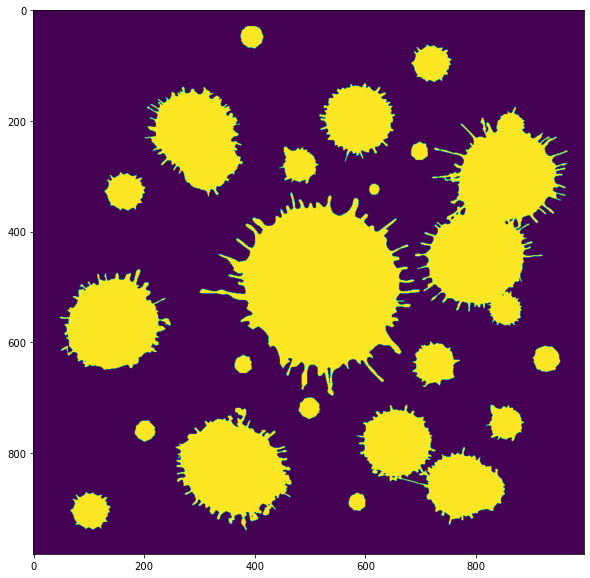

In [383]:
fig=plt.figure(figsize=(10, 10))
plt.imshow(exploration+track1)
plt.show()

In [382]:
car=Car(track.track, 50, track.spawn_at)
car.sampling_frequency=20.0

<h6> Declaring the training constants</h6>

In [345]:
insert_index=[0]
data_scaler=np.asarray([
    100, 100, 100, 100,
    100, 100, 100, 100,
    50, 1, 1, 1
])
gamma=0.8
usescaler=True
inputcolumns=[i for i in range(13) if i!=9]


In [ ]:

for train_step in range(99):
    if train_step%4==0:
        exploration=exploration*0
        populate_replay_memory(car, target_model, actions, replay_memory,
                               insert_index, replay_size, data_scaler, usescaler, train_step)
        np.random.shuffle(replay_memory)
        fig=plt.figure(figsize=(10, 10))
        plt.imshow(exploration+track1)
        plt.show()
        
    train_y=train_y*0
    train_y[:,0]=train_y[:,0]+replay_memory[:,23]
    train_y[:,1]=train_y[:,1]+replay_memory[:,24]
    train_x=replay_memory[:,inputcolumns]
    if usescaler:
        train_x=custom_scaler(train_x, data_scaler)
        
        
    make_consistent_net.fit(train_x, train_y, batch_size=1, epochs=5, verbose=1, shuffle=True,
                            validation_split=0.1, callbacks=[early_stop, history, learning_scheduler])
    
    
    val_loss_hist=val_loss_hist+history.history['val_loss']
    train_loss_hist=train_loss_hist+history.history['loss']
    
    
    if train_step%4==0:
        plt.plot(make_consistent_net.predict(train_x)[:200])
        plt.plot(0.96*target_model.predict(train_x)[:200].reshape((200, ))+replay_memory[:200, -2])
        
    target_model.set_weights(make_consistent_net.get_weights())
    update_replay_memory(target_model, actions, replay_memory,
                         data_scaler, usescaler)
    

    

In [ ]:
target_model.save("TrainedModels/trainedModel1.h5")

In [ ]:
# 0.9*target_model.predict(train_x)[:1000].reshape((1000, ))+
a=make_consistent_net.predict(train_x)[:400].reshape((400, ))
b=replay_memory[:400, -2]
print(a.shape, b.shape)
sum(np.logical_and(a>-1, b<0))

In [ ]:
((make_consistent_net.predict(train_x))).max()

In [401]:
make_consistent_net.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            multiple                  650       
_________________________________________________________________
layer_normalization_124 (Lay multiple                  100       
_________________________________________________________________
dense_201 (Dense)            multiple                  10200     
_________________________________________________________________
layer_normalization_125 (Lay multiple                  400       
_________________________________________________________________
dense_202 (Dense)            multiple                  4020      
_________________________________________________________________
layer_normalization_126 (Lay multiple                  40        
_________________________________________________________________
dense_203 (Dense)            multiple                